In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras 
import tensorflow.keras.utils as utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%load_ext tensorboard
import easydict

%matplotlib inline



In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')


tf.config.experimental.set_virtual_device_configuration(
    gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10444)])


In [4]:
cifar_train, cifar_test = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar_train, cifar_test

In [5]:
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)


In [6]:
TARGET_SIZE_H, TARGET_SIZE_W = (224, 224)


In [7]:
VALIDATION_SPLIT = 0.1

train_datagen = ImageDataGenerator(
    featurewise_center=True, 
    samplewise_center=False,
    featurewise_std_normalization=True, 
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rescale= 1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range= 0.2, 
    horizontal_flip=True, 
    fill_mode='nearest', 
    validation_split=VALIDATION_SPLIT
)

test_datagen = ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=False,
    featurewise_std_normalization=True,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
train_datagen.fit(x_train)
test_datagen.fit(x_train)


In [9]:
IMAGE_COUNT = len(x_train)
BATCH_SIZE = 20
STEPS_PER_EPOCH = np.ceil((IMAGE_COUNT - IMAGE_COUNT * VALIDATION_SPLIT)/BATCH_SIZE)
IMAGE_COUNT, STEPS_PER_EPOCH

(50000, 2250.0)

In [10]:
train_generator = train_datagen.flow(x_train, y_train,
    batch_size=BATCH_SIZE, 
    subset='training',
    shuffle=True,
    seed=42
)
validation_generator = train_datagen.flow(x_train, y_train,
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=True,
    seed=42
)

residual net

In [11]:
from ResidualNet import ResidualNet, DefaultConv2D
from datetime import datetime
import keras_tuner as kt
from keras_tuner import HyperParameters as hp
date_time = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")

def net_fn():
    # with strategy.scope():
    model = keras.Sequential(name=f'Residual_Net_{date_time}')
    model.add(tf.keras.layers.Lambda(
        lambda image: tf.image.resize(image, (TARGET_SIZE_H, TARGET_SIZE_W))))
    model.add(DefaultConv2D(64, kernel_size=7,
                            input_shape=(TARGET_SIZE_H, TARGET_SIZE_W, 3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(tf.nn.relu))
    model.add(keras.layers.MaxPool2D(
          pool_size=(3, 3), strides=(2, 2), padding='same'))
    prev_filters = 64
    for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
            strides = 1 if filters == prev_filters else 2
            model.add(ResidualNet(filters, strides=strides))
            prev_filters = filters
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(10, activation='softmax'))

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    loss = tf.keras.losses.CategoricalCrossentropy()

    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
   
    return model

In [12]:
net = net_fn()
history = net.fit(train_generator, validation_data=validation_generator,
                      verbose=2, workers=6, epochs=50, steps_per_epoch=STEPS_PER_EPOCH)


Epoch 1/50
2250/2250 - 469s - loss: 1.9990 - accuracy: 0.2564 - val_loss: 1.7125 - val_accuracy: 0.3604
Epoch 2/50
2250/2250 - 474s - loss: 1.5520 - accuracy: 0.4373 - val_loss: 1.4376 - val_accuracy: 0.4960
Epoch 3/50
2250/2250 - 472s - loss: 1.2526 - accuracy: 0.5526 - val_loss: 1.2864 - val_accuracy: 0.5550
Epoch 4/50
2250/2250 - 480s - loss: 1.0597 - accuracy: 0.6291 - val_loss: 1.1060 - val_accuracy: 0.6118
Epoch 5/50
2250/2250 - 478s - loss: 0.9249 - accuracy: 0.6775 - val_loss: 0.9717 - val_accuracy: 0.6572
Epoch 6/50
2250/2250 - 499s - loss: 0.8241 - accuracy: 0.7143 - val_loss: 0.8553 - val_accuracy: 0.7066
Epoch 7/50
2250/2250 - 482s - loss: 0.7424 - accuracy: 0.7426 - val_loss: 0.7189 - val_accuracy: 0.7516
Epoch 8/50
2250/2250 - 475s - loss: 0.6768 - accuracy: 0.7667 - val_loss: 0.6494 - val_accuracy: 0.7730
Epoch 9/50
2250/2250 - 476s - loss: 0.6207 - accuracy: 0.7854 - val_loss: 0.5953 - val_accuracy: 0.8000
Epoch 10/50
2250/2250 - 471s - loss: 0.5818 - accuracy: 0.7982 -

In [13]:
test_generator = test_datagen.flow(x_test, y_test)

In [14]:
score = net.evaluate(test_generator, workers=8,verbose=2)

313/313 - 25s - loss: 0.3994 - accuracy: 0.8833


Training accuracy:  0.9639777541160583
Training loss:  0.10332419723272324
Validation accuracy:  0.9065999984741211
Validation loss:  0.3246690332889557


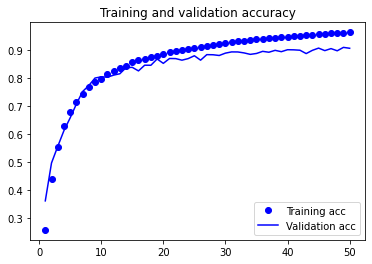

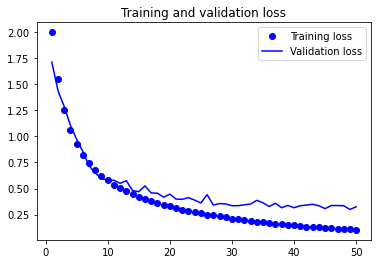

In [15]:

acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print("Training accuracy: ", acc)
print("Training loss: ", loss)

print("Validation accuracy: ", val_acc)
print("Validation loss: ", val_loss)

# Plotting the graphs to visualize the trend of accuracy and loss

epochs = range(1, len(history.history['accuracy'])+1)

plt.plot(epochs, history.history['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()